In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
# np.seterr(divide='ignore') # these warnings are usually harmless for this code
# np.random.seed(0)
from matplotlib import pyplot as plt
import matplotlib
import os
matplotlib.rcParams['font.size'] = 12
plt.rcParams.update({'figure.figsize':[18,6]})

import sys
import pyhsmm
import pyhsmm.basic.distributions as distributions

sys.path.append('/home/kirilman/Projects/nir/main nir')
import myutils
import sequence_generator as generator
from HMMClassifier import SignalManager
import pomegranate as pg
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.general import rle
from myutils import plot_signal_label
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import logistic
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# np.random.seed(42)

In [6]:
def abnormals_insert(signal,size = 40):
    t = signal.copy()
    start = np.random.randint(0,len(signal) - size,)
    m = np.random.uniform(min(signal),max(signal))
    sigma = 0.3
    t[start:start+size] = np.random.normal(m,sigma,size)
    return t

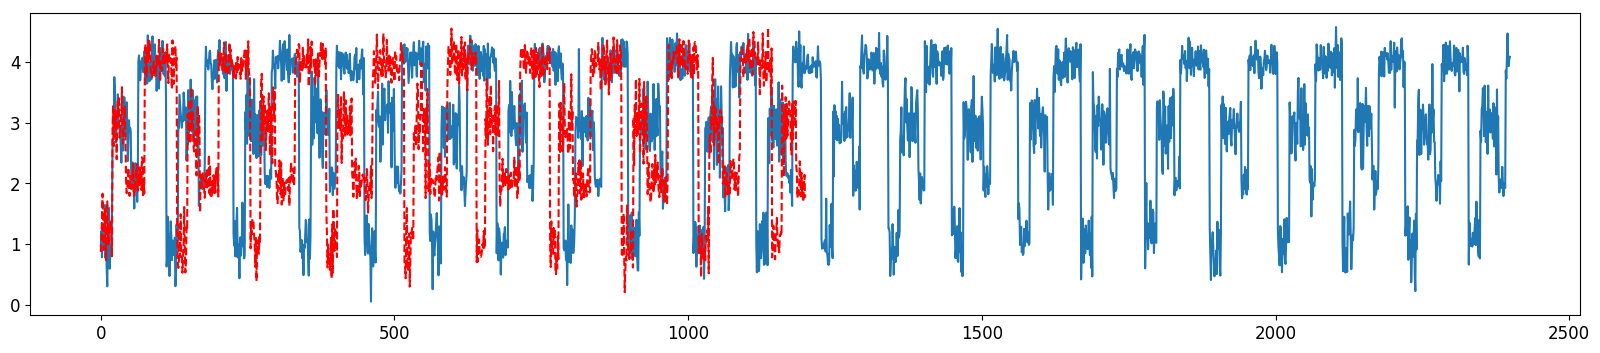

In [7]:
T = 1200
fig = plt.figure(figsize=(20,4),dpi = 100)
signal_manager = SignalManager()
signal_manager.read_paramets('config_hsmm.json')
signal = np.array(signal_manager.generators[0].sequence).reshape(-1,1)

test_signal = np.array(signal_manager.generators[1].sequence).reshape(-1,1)
plt.plot(signal[:,0])
plt.plot(test_signal[:,0],'r--')
n_comp = 4

signal_for_lvl = np.array([signal_manager.generators[0].generate_signal()[:T] for _ in range(10)])

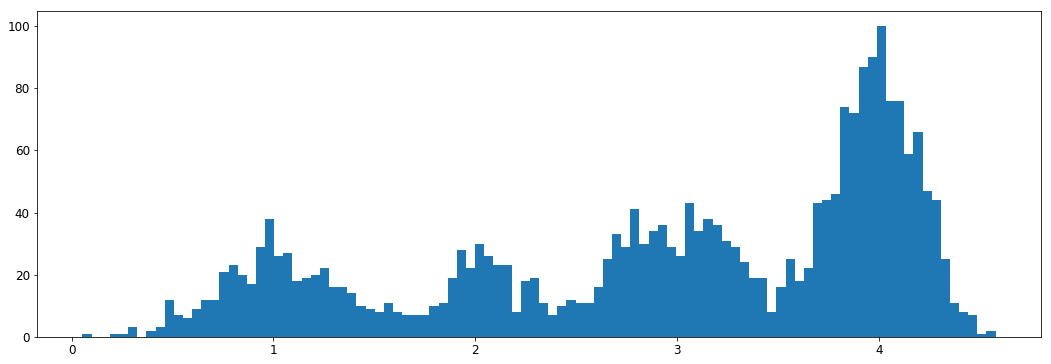

In [8]:
plt.hist(signal,100);

In [9]:
#fit model
def create_model(data, Nmax):
    obs_dim = 1
    dur_distns = []
    Nmax = 7
#     L = 5
#     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
#                     'K':L,
#                      'alphav_0':np.zeros(L)+0.1, 
#                      'alpha_mf':np.zeros(L)+0.1,
#                     }

    obs_hypparams = {'mu_0':np.zeros(obs_dim),
                    'sigma_0':np.eye(obs_dim),
                    'kappa_0':2,
                    'nu_0':obs_dim+5}
    obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]

    
    dur_hypparams = {'alpha_0':45,
                     'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':20,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':30,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':55,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    
    
    dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

    posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
            alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
            init_state_concentration=6., # pretty inconsequential
            obs_distns=obs_distns,
            dur_distns=dur_distns)

#     posteriormodel = pyhsmm.models.HSMM(
#             alpha=6., # На что влияет 
# #             gamma=2., # better to sample over these; see concentration-resampling.py
#             init_state_concentration=6., # pretty inconsequential
#             obs_distns=obs_distns,
#             dur_distns=dur_distns)
    
    posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
    
    fig = plt.figure(figsize=(12,10),dpi = 140)
    for idx in progprint_xrange(150):
        posteriormodel.resample_model(1)
    plt.show()
    return posteriormodel

In [10]:
from multiprocessing import Pool
class hsmm_classifier():
    def __init__(self, N = 5):
        self.models = []
        self.number_model = N
        
    def fit(self,data):
        pool = Pool(self.number_model)
        params = [ (data, i + 10) for i in range(self.number_model)]
        self.models = pool.starmap(self.create_model, params)
    
    def log_likelihood(self, data):
#         pool = Pool(self.number_model)
#         return pool(self.models.log_likelihood, [(data,)*self.number_model])
        return np.array([m.log_likelihood(data) for m in self.models])
    
    def test(self):
        for m in self.models:
            print(m.generate(10,1))
            
    def create_model(self,data,seed):
        np.random.seed(seed)
        obs_dim = 1
        dur_distns = []
        Nmax = 7
    #     L = 5
    #     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
    #                     'K':L,
    #                      'alphav_0':np.zeros(L)+0.1, 
    #                      'alpha_mf':np.zeros(L)+0.1,
    #                     }

        obs_hypparams = {'mu_0':np.zeros(obs_dim),
                        'sigma_0':np.eye(obs_dim),
                        'kappa_0':2,
                        'nu_0':obs_dim+5}
        obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]


        dur_hypparams = {'alpha_0':45,
                         'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':20,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':30,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':55,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]


        dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

        posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
                alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
                init_state_concentration=6., # pretty inconsequential
                obs_distns=obs_distns,
                dur_distns=dur_distns)

    #     posteriormodel = pyhsmm.models.HSMM(
    #             alpha=6., # На что влияет 
    # #             gamma=2., # better to sample over these; see concentration-resampling.py
    #             init_state_concentration=6., # pretty inconsequential
    #             obs_distns=obs_distns,
    #             dur_distns=dur_distns)

        posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
        for idx in progprint_xrange(150):
            posteriormodel.resample_model(1)
        return posteriormodel
    def get_models(self):
        return self.models

In [11]:
classifiear = hsmm_classifier(N = 3)
classifiear.fit(signal[:500])

Конструктор
Конструктор
Конструктор


/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


...................................................................  [  25/150,    0.12sec avg, ETA 15.15 ]
........  [  25/150,    0.13sec avg, ETA 16.78 ]
....  [  25/150,    0.14sec avg, ETA 18.09 ]
................................................................  [  50/150,    0.13sec avg, ETA 12.78 ]
........  [  50/150,    0.13sec avg, ETA 13.48 ]
.....  [  50/150,    0.14sec avg, ETA 14.04 ]
.........................................................  [  75/150,    0.13sec avg, ETA 9.44 ]
................  [  75/150,    0.13sec avg, ETA 10.11 ]
....  [  75/150,    0.14sec avg, ETA 10.36 ]
...................................................  [ 100/150,    0.13sec avg, ETA 6.30 ]
....................  [ 100/150,    0.13sec avg, ETA 6.73 ]
......  [ 100/150,    0.14sec avg, ETA 6.92 ]
...............................................  [ 125/150,    0.13sec avg, ETA 3.18 ]
..................  [ 125/150,    0.13sec avg, ETA 3.35 ]
..............  [ 125/150,    0.14sec avg, ETA 3.48 ]
...

100 1200


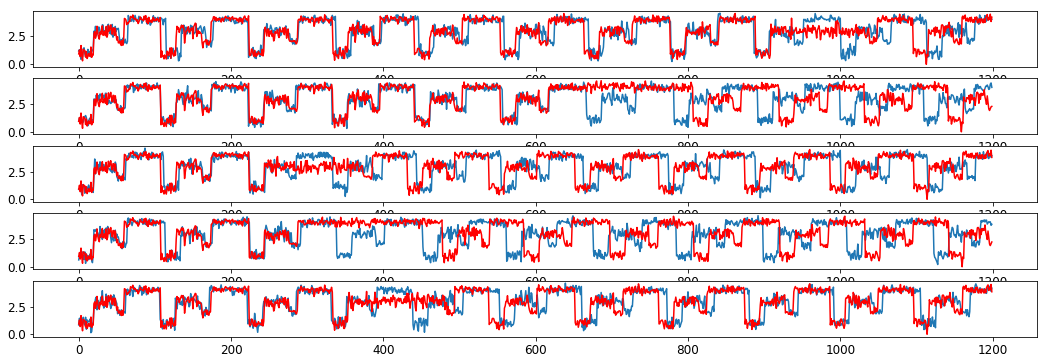

In [12]:
x_test = []
M = 50
signal_manager.generators[0].n = T
y_true = np.array([0]*M+[1]*M)
for i in range(M):
    x_test +=[signal_manager.generators[0].generate_signal()[:T]]
    
for i in range(M):
    x_test +=[signal_manager.generators[0].extend_condition(4)[:T]]
    
print(len(x_test),len(x_test[0]))

for i,(x,y) in enumerate(zip(x_test,x_test[M:M+5])):
    ax = plt.subplot(5,1,i+1)
    plt.plot(x)
    plt.plot(y,'r')

# x_test = []
# y_true = np.array([0]*15+[1]*15)
# for i in range(15):
#     x_test +=[signal_manager.generators[0].generate_signal()]
    
# for i in range(15):
#     x_test +=[signal_manager.generators[0].get_abnormal_signal()]
# print(len(x_test),len(x_test[0]))

In [14]:
%%time
from multiprocessing import Pool
def do_log_likelihood(args):
    model, data = args
    ll = []
    for x in data:
        ll += [model.log_likelihood(x.reshape(-1,1))]
    return np.array(ll)
pool = Pool()
x_test = np.array(x_test)

res = pool.map(do_log_likelihood, [ (m, x_test) for m in classifiear.models])

pool.close()
pool.join()


/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


CPU times: user 66.5 ms, sys: 49.9 ms, total: 116 ms
Wall time: 46.2 s


In [15]:
res

[array([-663.35072065, -638.74338087, -650.65923498, -664.73136144,
        -662.42158519, -643.98376404, -637.7949629 , -673.75595855,
        -653.47292595, -634.59047188, -633.56548875, -634.74520565,
        -666.65672511, -654.78507404, -646.19661477, -662.43092806,
        -650.6987296 , -648.93157842, -656.26788725, -657.52456784,
        -649.40649783, -654.9999949 , -667.28374126, -655.94720964,
        -645.00296501, -646.88263303, -650.9992157 , -659.32538017,
        -643.39486038, -660.58945   , -653.1134474 , -650.62244151,
        -642.21786629, -664.79360429, -632.34528551, -651.44966173,
        -644.19928097, -651.29775284, -619.06187605, -653.10260575,
        -649.58750347, -638.71119782, -662.79240104, -665.23693305,
        -661.01470048, -643.60925819, -661.98596919, -652.16365057,
        -617.56046235, -643.50693394, -689.02997783, -675.59354161,
        -696.1874866 , -665.25522289, -692.64890341, -670.61660409,
        -677.49195379, -666.8888024 , -675.47455

In [ ]:
hsmm = create_model(signal, n_comp)
print(hsmm.used_states)

In [ ]:
hsmm.plot_duration()

In [ ]:
hsmm.used_states

In [ ]:
print('ll train: {} , test: {}'.format(hsmm.log_likelihood(signal[:T]), hsmm.log_likelihood(test_signal)))

In [ ]:
def score(model, x_test, y_test, log_prob_normal ,train_signal,num_plot,lvl = 0.1, signal_for_lvl = None, 
          degree_std = 3):
    
    x_test = np.array(x_test)
    log_scores = []
    anomals = []
    if signal_for_lvl is None:
        low = log_prob_normal*(1-lvl)
        high = log_prob_normal*(1+lvl)
        if log_prob_normal<0:
            low, high = high, low
    else:
        ll = np.array([model.log_likelihood( np.array(s).reshape(-1,1)) for s in signal_for_lvl])
        mean, std = norm.fit(ll)
        low = mean - degree_std*std
        high = log_prob_normal + 5*std
        print('mean = {}, std = {}'.format(mean, std))
        
    print('Нижний порог {}, верхний порог {}'.format(low, high))
    y_pred = np.zeros(shape=(len(x_test),),dtype=np.int)
    
    start_time = time()
    for k,x in enumerate(x_test):
        p = model.log_likelihood(x.reshape(-1,1))
        if k == 1:
            print(p)
        log_scores+=[p]
        if p<low:
            anomals+=[x]
            y_pred[k] = 1
    log_scores = np.array(log_scores)
    print('Время для log-like: ', time() - start_time)
    print(len(anomals))
    print('Y_pred ', y_pred.sum())
    
#     return log_scores, y_pred
    f_score = f1_score(y_test, y_pred)

#Гистограмма ll
    #для нормальный
    plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
    fig = plt.figure(dpi = 90, figsize=(12,6))
    plt.hist(log_scores[y_test == 0],int(x_test.shape[0]/8),rwidth = 0.9, color='green');
    plt.axvline(x=log_prob_normal)
    plt.axvline(low,color='black')
    plt.ylabel('N')
    plt.xlabel('Log-likelihood')
    #для аномальных
    plt.hist(log_scores[y_test == 1],int(x_test.shape[0]/8),color = 'r',alpha = 0.8, rwidth = 0.9);
    plt.savefig('Гистограмма.jpeg', dpi = 150);
    
    fig = plt.figure(figsize=(18,5*num_plot))
#     plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12)
    for i in range(num_plot):
        ax = plt.subplot(num_plot, 1, i+1)
        plt.plot(train_signal,'g')
        k = np.random.choice(len(anomals))
        plt.plot(anomals[k],'r--');
    # plt.tight_layout()
    plt.savefig('Как аномальные.jpeg',dpi = 80)
#     print('x_test',x_test.shape)
#     print('index',np.where(y_pred == 0))    
#     print('y_pred',y_pred.shape)
#     print(x_test[np.where(y_pred == 0)])    
#     print(x_test[np.where(y_pred == 0)].shape)    

    fig = plt.figure(figsize=(18,5*num_plot))
    plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12)
    
    normals = x_test[y_pred == 0]
    
    print('normals',normals.shape)
    for i in range(num_plot):
        ax = plt.subplot(num_plot, 1, i+1)
        plt.plot(train_signal,'g');
        k = np.random.choice(len(normals))
        plt.plot(normals[k],'r--');
    # plt.tight_layout()
    plt.savefig('Как нормальные.jpeg',dpi = 80)
    return log_scores, y_pred

In [ ]:
plt.figure(figsize=(19,4),dpi = 200)
for i,(x,y) in enumerate(zip(x_test,x_test[M+1:M+2])):
    ax = plt.subplot(1,1,i+1)
    plt.plot(x[:])
    plt.plot(y[:],'r')

In [ ]:
hsmm.log_likelihood(signal[:T])

In [ ]:
%%time
x_, y_ = score(hsmm,x_test,y_true, hsmm.log_likelihood(signal[:T]), signal[:T], num_plot=1,lvl = 0.08,
               signal_for_lvl = signal_for_lvl, degree_std = 2)

In [ ]:
fig = plt.figure(figsize=(4,3), dpi = 150,)
plt.hist(x_, 40, color ='blue');

In [ ]:
x_test[260][:4]

In [ ]:
t = np.array([hsmm.log_likelihood(np.array(x_test[260][:i]).reshape(-1,1)) if i > 5 else 0.0 for i in range(20)])
plt.plot(t)

In [ ]:
plt.plot(x_test[260])
ll = np.array([hsmm.log_likelihood(np.array(x_test[260][:i]).reshape(-1,1)) if i > 5 else 0.0 
                                                            for i in range(len(x_test[0]))])
plt.plot(ll)

In [ ]:
plt.subplot(3,1,1)
plt.plot(x_test[260])
plt.subplot(3,1,2)
plt.plot(ll)
plt.subplot(3,1,3)
# plt.plot(np.diff(ll,1))
plt.plot(np.cumsum(ll))

## Проверка инициализации разных моделей

In [ ]:
%%time
signals = np.array(x_test)
for i,x in enumerate(signals):
    if i == 0:
        ll = classifiear.log_likelihood(x.reshape(-1,1))
    else:
        ll = np.vstack((ll, classifiear.log_likelihood(x.reshape(-1,1))))

In [ ]:
ll_normal = classifiear.log_likelihood(signal[:1200])

In [ ]:
plt.figure()
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(ll[:200,i],40, color = 'green')
    plt.hist(ll[200:,i],40, color = 'red', alpha = 0.85)
    plt.axvline(ll_normal[i],color='blue')

### Оценка нижнего порога

In [ ]:
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import logistic

plt.hist(ll,10,color='r', normed=True);
mean, std = norm.fit(ll)
xx = np.linspace(mean - 5*std, mean + 5*std,200)
print(mean, std)
pdf = norm.pdf(xx,mean, std)
plt.plot(xx,pdf,color='black')

loc, scale = logistic.fit(ll)
laplace_pdf = logistic.pdf(xx,loc, scale)

plt.plot(xx, laplace_pdf,'green')
plt.axvline(mean - 3*std)

In [ ]:
ind = np.where((x_> - 525) & (y_true == 1))
fig = plt.figure(figsize=(20,40))
for i,x in enumerate(np.array(x_test)[ind]):
    plt.subplot(15,2,i+1,); i+=1
    plt.plot(signal[:T],'r')
    plt.plot(x)
    if i == 30:
        break

In [ ]:
fig = plt.figure(figsize=(20,4),dpi = 150)
plt.plot(x_, linewidth=2,)
plt.plot(range(len(x_)),[hsmm.log_likelihood(signal[:T])]*len(x_),'green', linewidth=2,label = 'Log-likelihood для обучения')
plt.xlabel('№ сигнала')
plt.ylabel('Log-likelihood')
plt.legend()
plt.savefig('log.jpeg',dpi = 150)

In [ ]:
states = hsmm.predict(np.array(x_test[150]).reshape(-1,1),1)[1]
plt.plot(np.array(x_test[150]))
plt.plot(states)

In [ ]:
np.array(x_test[0]).reshape(-1,1).shape

In [ ]:
%time z = [hsmm.log_likelihood(np.array(x_test[0]).reshape(-1,1))for i in range(100)]

In [ ]:
f1_score(y_true, y_)

In [ ]:
print(np.sum(y_[:100]))
ind = list(filter( lambda x: x< 100, np.where(y_ == 1)[0]))
print(ind)
i = 0
fig = plt.figure(figsize=(20,40))

for ll, x in zip(x_[ind], np.array(x_test)[ind]):
    plt.subplot(15,2,i+1,); i+=1
    plt.plot(x)
    plt.plot(signal[:T],'r')
    plt.title('{}'.format(ll))
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [ ]:
ind = list(filter( lambda x: x> 100, np.where(y_ == 0)[0]))
print(ind)
i = 0
fig = plt.figure(figsize=(20,40))

for x in np.array(x_test)[ind]:
    plt.subplot(15,2,i+1,); i+=1
    plt.plot(x)
    if i == 30:
        break
plt.show()

In [ ]:
signals = []
for i in range(1000):
    signals+=[signal_manager.generators[0].generate_signal()[:T]]
signals = np.array(signals)
ll = np.zeros((1000,))
for k, x in enumerate(signals):
    ll[k] = hsmm.log_likelihood(x.reshape(-1,1))

In [ ]:
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import logistic

plt.hist(ll,30,color='r', normed=True);
mean, std = norm.fit(ll)
xx = np.linspace(mean - 5*std, mean + 5*std,200)
print(mean, std)
pdf = norm.pdf(xx,mean, std)
plt.plot(xx,pdf,color='black')

loc, scale = logistic.fit(ll)
laplace_pdf = logistic.pdf(xx,loc, scale)

plt.plot(xx, laplace_pdf,'green')

In [ ]:
fig = plt.figure(figsize=(20,80))
for i in range(20):
    ax = plt.subplot(20, 1, i+1)
    plt.plot(signal,'g')
    plt.plot(anomals[np.where(log_scores>-240)[0][i]],'r--')
# plt.tight_layout()
plt.savefig('Сравнение аномальный сигналов с нормальным.jpeg',dpi = 80)

In [ ]:
fig = plt.figure(figsize=(20,80))
for i in range(20):
    ax = plt.subplot(20, 1, i+1)
    plt.plot(signal,'g')
    plt.plot(anomals[np.where(log_scores<-240)[0][i]],'r--')
# plt.tight_layout()
plt.savefig('Сравнение аномальный сигналов с нормальным более аномальные.jpeg',dpi = 80)

In [ ]:
models = [ create_model(signal,7) for i in range(5)]

In [ ]:
for model in models:
    print(' ll = ', model.log_likelihood(signal))

##Аномал скор нарастающий

In [ ]:
def compute_anomal_score(model, seq):
    if isinstance(seq, list):
        seq = np.array(seq)
        seq = seq.reshape(-1,1)
    b = np.zeros((seq.shape[0],))
  
    for i in range(seq.shape[0]):
        if i == 0:
            continue
        b[i] = model.log_likelihood(seq[:i])
    return -b.sum()/len(b), b 

In [ ]:
s, score = compute_anomal_score(hsmm,x_test[0])

In [ ]:
plt.plot(score)